## Perform linear regression on experimental data to continuously approximate how cell compositions change with growth rate. 

### Gather experimental values of ribosomes, ternary complexes, cell mass, and cell volume as a function of growth rate from literature.

In [1]:
import numpy as np
import matplotlib.pyplot as plt


#Active Ribosomes
x_rib = np.array([0.6,1.0,1.5,2.0,2.5,3.0])
y_rib = np.array([8000,15000,26000,44000,61000,73000])
y_rib = np.array([int(y_i*0.85) for y_i in y_rib])

#Ternary complexes
x_tern = np.array([0.4,0.7,1.07,1.6,2.5,3.0]+[0.4]*5)
y_tern = np.array([48000,57000,83000,143000,323000,383000]+[48000]*5)

#Cell mass
x_mass = np.array([0.6,1.0,1.5,2.0,2.5,3.0])
y_mass = np.array([159,257,370,512,607,636])

## Cell Volume
x_vol = np.array([0.25,0.42,0.56,0.58,0.68,0.71,0.87,1.81,1.85,2.15,2.3])
y_vol = np.array([1.14,1.44,1.74,1.26,1.11,1.38,1.44,2.15,2.34,2.46,2.4])

##Nucleoid volume
x_nuc = np.array([0.4,1.36,2.85])
y_nuc = np.array([0.17,0.13,0.11])


x_vals = np.array([x_rib, x_tern, x_mass, x_vol,x_nuc])
y_vals = np.array([y_rib, y_tern, y_mass, y_vol,y_nuc])
label_vals = np.array(["Ribosomes", "Ternary complexes", "Cell mass", "Cell volume","Nucleoid volume fraction"])

### Perform bootstrapping of different polynomial fits (i.e., 0th order, 1st order, and 2nd order polynomial) to find the best order polynomial to fit each experimental dataset (i.e., the lowest-complexity model that can best predict experimental data)

In [2]:
def bootstrap(x,y,order):
    MAE_tot=0
    B=10000
    for i in range(B):
        boot_indices = np.random.choice(np.arange(len(x)),len(x))
        
        if(len(np.unique(np.take(x,boot_indices)))>order):
            y_model = np.polyfit(np.take(x, boot_indices),np.take(y,boot_indices),order)
            for i,x_i in enumerate(x):
                y_i_hat = np.polyval(y_model,x_i)
                MAE_boot = np.abs(y[i] - y_i_hat)
                MAE_tot += MAE_boot
                
    MAE_avg = MAE_tot/B-1
    return MAE_avg

np.random.seed(1)
for i in range(len(x_vals)):
    print("\n",label_vals[i])
    bootstrap_scores = list()
    poly_powers = [0,1,2]
    
    #Try fitting 0th, 1st, and 2nd order polynomials
    for order in poly_powers:
        #If there are more data than the order of polynomial being fit, then try that order
        if(len(x_vals[i])-1>order):
            bootstrap_scores.append(bootstrap(x_vals[i],y_vals[i],order))
    print("Boostrap MAE: ", ['{:.2e}'.format(score) for score in bootstrap_scores], ", Min order: ", np.argmin(bootstrap_scores))


 Ribosomes
Boostrap MAE:  ['1.13e+05', '1.25e+04', '1.31e+04'] , Min order:  1

 Ternary complexes
Boostrap MAE:  ['1.02e+06', '2.22e+05', '8.01e+04'] , Min order:  2

 Cell mass
Boostrap MAE:  ['9.96e+02', '1.61e+02', '1.26e+02'] , Min order:  2

 Cell volume
Boostrap MAE:  ['4.14e+00', '6.56e-01', '1.09e+00'] , Min order:  1

 Nucleoid volume fraction
Boostrap MAE:  ['-9.28e-01', '-9.76e-01'] , Min order:  1


### Fit polynomials to data and calculate R^2 values

241
[0.99, 0.99, 0.99, 0.87, 0.9]


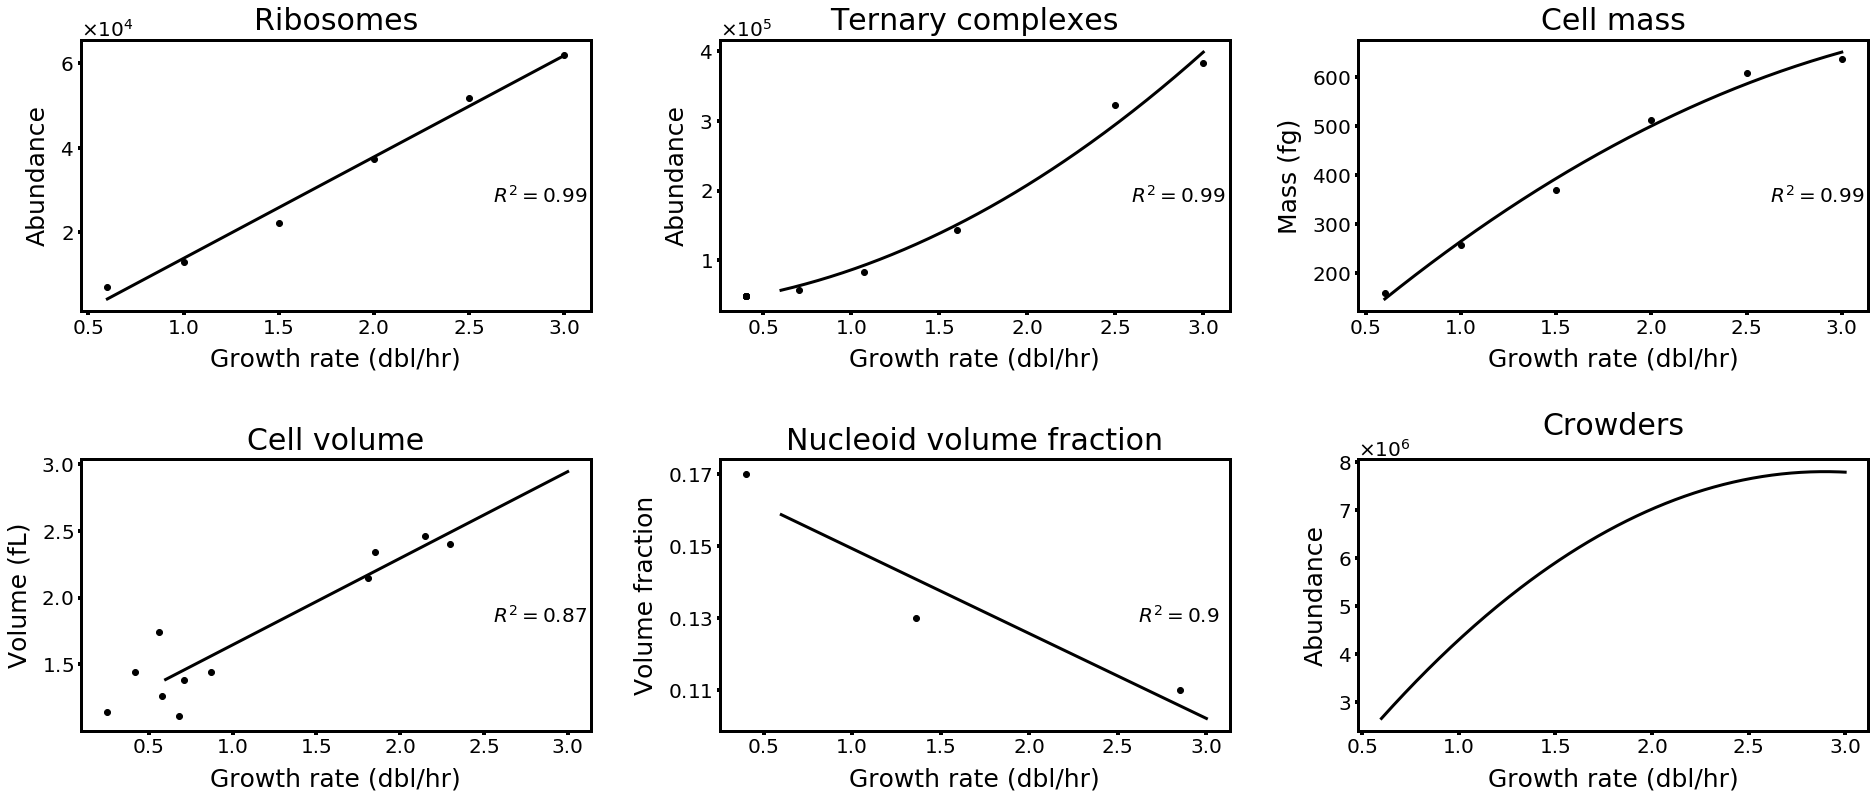

In [3]:
#Calculation of polynomial fits are in analysis_parameters.py
from analysis_parameters import *
from sympy import S, symbols, expand, Symbol
import sympy
import matplotlib.ticker as mticker

dbl_rate=np.arange(0.6,3.01,0.01)
def calc_R2(x,y,y_hat):
    SS_tot = np.sum((y-np.average(y))**2) #Sum of squares total (proportional to variance; n times larger than variance)
    SS_err = np.sum((y-y_hat)**2) # Sum of squared errors
    return 1-SS_err/SS_tot

dbl_rate_list = list()
for i in range(len(label_vals)):
    dbl_rate_list.append(np.arange(0.6,3.01,0.01))#min(x_vals[i]) instead of 0.6
print(len(dbl_rate))
crowderAbundance = list()
for i in range(len(dbl_rate)):
    cell_volfrac_tot = list()
    cellParams, voxelParams = calcParams(f_rib(dbl_rate[i]),
                                               f_tern(dbl_rate[i]),
                                               f_mass(dbl_rate[i]),
                                               f_vol(dbl_rate[i]),
                                               f_nuc(dbl_rate[i]))
    crowderAbundance.append(cellParams[2][2])
ribs = [f_rib(i) for i in dbl_rate_list[0]]
tern = [f_tern(i) for i in dbl_rate_list[1]]
mass = [f_mass(i) for i in dbl_rate_list[2]]
vol = [f_vol(i) for i in dbl_rate_list[3]]
nuc = [f_nuc(i) for i in dbl_rate_list[4]]

fig,ax = plt.subplots(2,3,figsize=(27,12))
ax = ax.flatten()
y_labels = ['Abundance','Abundance','Mass (fg)','Volume (fL)', 'Volume fraction','Abundance']
y_fits = [ribs,tern,mass,vol,nuc]
fits = [lambda x:f_rib(x),lambda x:f_tern(x),lambda x:f_mass(x),lambda x:f_vol(x), lambda x:f_nuc(x)]
R2_arr = list()

ax[0].set_yticks(np.arange(0, 8*10**4, 2*10**4))
ax[1].set_yticks(np.arange(0, 5*10**5, 1*10**5))
ax[4].set_yticks(np.arange(0.01, 0.2, 0.02))
for i in range(len(y_vals)):
    R2_arr.append(np.around(calc_R2(x_vals[i],y_vals[i],fits[i](x_vals[i])),2))
    formatter = mticker.ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-3,3))
    ax[i].yaxis.offsetText.set_fontsize(20)
    ax[i].yaxis.set_major_formatter(formatter)
    ax[i].plot(dbl_rate_list[i],y_fits[i],color='black',linewidth=3)
    ax[i].scatter(x_vals[i],y_vals[i],color='black')
    #ax[i].set(xlim=(min(x_vals[i]),max(x_vals[i])), ylim=[min(y_vals[i]), max(y_vals[i])])
    ax[i].set_title(label_vals[i],fontsize=30,pad=10)
    ax[i].text(0.9,0.4,r'$R^2=$'+str(R2_arr[-1]),horizontalalignment='center',transform=ax[i].transAxes,fontsize=20)

for i in range(len(y_vals)+1):
    ax[i].spines['left'].set_linewidth(3)
    ax[i].spines['bottom'].set_linewidth(3)
    ax[i].spines['top'].set_linewidth(3)
    ax[i].spines['right'].set_linewidth(3)
    ax[i].set_ylabel(y_labels[i],size=25,labelpad=10)
    ax[i].set_xlabel('Growth rate (dbl/hr)',size=25,labelpad=10)
    ax[i].tick_params(axis='both', which='major',width=4, labelsize=20)

ax[5].yaxis.set_major_formatter(formatter)
ax[5].yaxis.offsetText.set_fontsize(20)
ax[5].set_title('Crowders',fontsize=30,pad=25)
ax[5].plot(dbl_rate,crowderAbundance,color='black',linewidth=3)
plt.tight_layout(pad=4.0)
print(R2_arr)

241
[0.99, 0.99, 0.99, 0.87, 0.9]


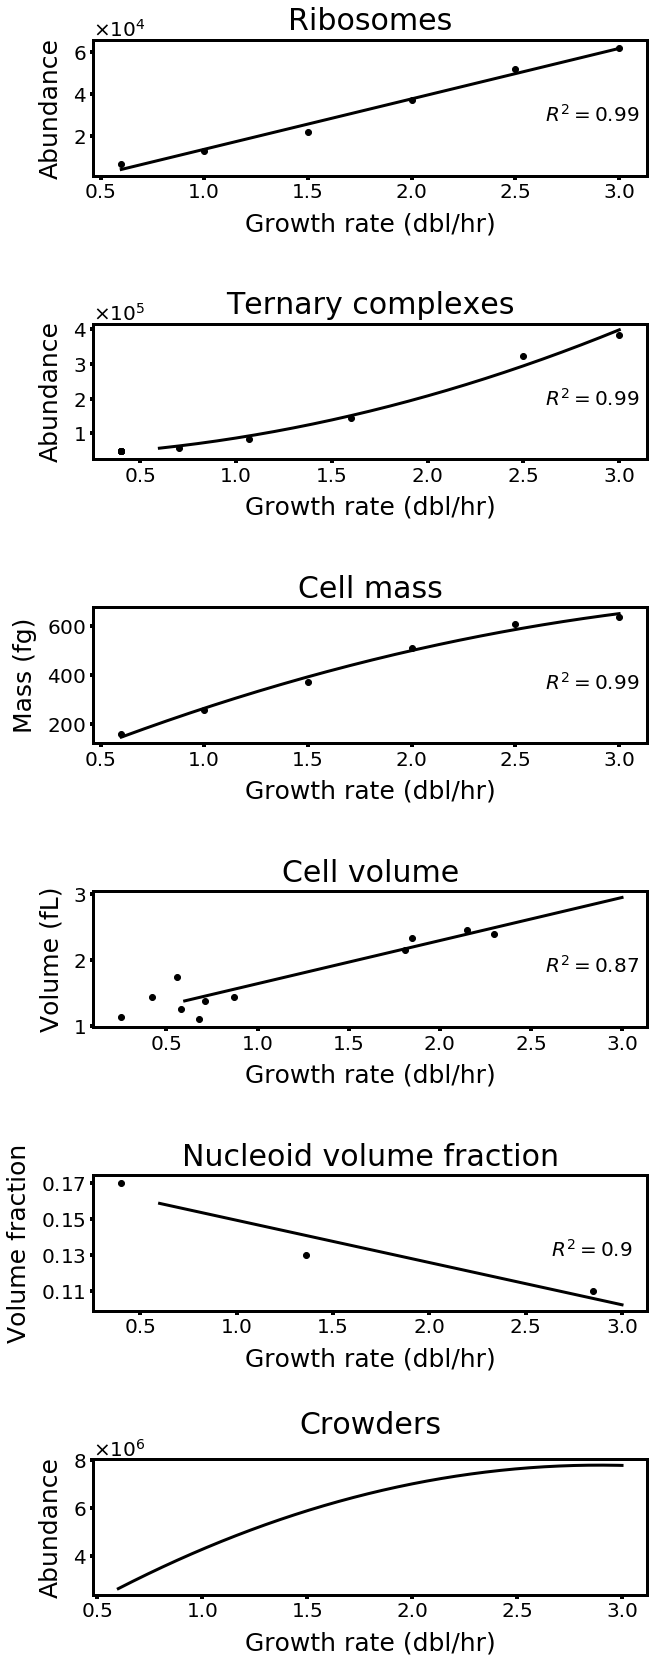

In [13]:
#Calculation of polynomial fits are in analysis_parameters.py
from analysis_parameters import *
from sympy import S, symbols, expand, Symbol
import sympy
import matplotlib.ticker as mticker

dbl_rate=np.arange(0.6,3.01,0.01)
def calc_R2(x,y,y_hat):
    SS_tot = np.sum((y-np.average(y))**2) #Sum of squares total (proportional to variance; n times larger than variance)
    SS_err = np.sum((y-y_hat)**2) # Sum of squared errors
    return 1-SS_err/SS_tot

dbl_rate_list = list()
for i in range(len(label_vals)):
    dbl_rate_list.append(np.arange(0.6,3.01,0.01))#min(x_vals[i]) instead of 0.6
print(len(dbl_rate))
crowderAbundance = list()
for i in range(len(dbl_rate)):
    cell_volfrac_tot = list()
    cellParams, voxelParams = calcParams(f_rib(dbl_rate[i]),
                                               f_tern(dbl_rate[i]),
                                               f_mass(dbl_rate[i]),
                                               f_vol(dbl_rate[i]),
                                               f_nuc(dbl_rate[i]))
    crowderAbundance.append(cellParams[2][2])
ribs = [f_rib(i) for i in dbl_rate_list[0]]
tern = [f_tern(i) for i in dbl_rate_list[1]]
mass = [f_mass(i) for i in dbl_rate_list[2]]
vol = [f_vol(i) for i in dbl_rate_list[3]]
nuc = [f_nuc(i) for i in dbl_rate_list[4]]

fig,ax = plt.subplots(6,1,figsize=(10,24))
ax = ax.flatten()
y_labels = ['Abundance','Abundance','Mass (fg)','Volume (fL)', 'Volume fraction','Abundance']
y_fits = [ribs,tern,mass,vol,nuc]
fits = [lambda x:f_rib(x),lambda x:f_tern(x),lambda x:f_mass(x),lambda x:f_vol(x), lambda x:f_nuc(x)]
R2_arr = list()

ax[0].set_yticks(np.arange(0, 8*10**4, 2*10**4))
ax[1].set_yticks(np.arange(0, 5*10**5, 1*10**5))
ax[4].set_yticks(np.arange(0.01, 0.2, 0.02))
for i in range(len(y_vals)):
    R2_arr.append(np.around(calc_R2(x_vals[i],y_vals[i],fits[i](x_vals[i])),2))
    formatter = mticker.ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-3,3))
    ax[i].yaxis.offsetText.set_fontsize(20)
    ax[i].yaxis.set_major_formatter(formatter)
    ax[i].plot(dbl_rate_list[i],y_fits[i],color='black',linewidth=3)
    ax[i].scatter(x_vals[i],y_vals[i],color='black')
    #ax[i].set(xlim=(min(x_vals[i]),max(x_vals[i])), ylim=[min(y_vals[i]), max(y_vals[i])])
    ax[i].set_title(label_vals[i],fontsize=30,pad=10)
    ax[i].text(0.9,0.4,r'$R^2=$'+str(R2_arr[-1]),horizontalalignment='center',transform=ax[i].transAxes,fontsize=20)

for i in range(len(y_vals)+1):
    ax[i].spines['left'].set_linewidth(3)
    ax[i].spines['bottom'].set_linewidth(3)
    ax[i].spines['top'].set_linewidth(3)
    ax[i].spines['right'].set_linewidth(3)
    ax[i].set_ylabel(y_labels[i],size=25,labelpad=10)
    ax[i].set_xlabel('Growth rate (dbl/hr)',size=25,labelpad=10)
    ax[i].tick_params(axis='both', which='major',width=4, labelsize=20)

ax[5].yaxis.set_major_formatter(formatter)
ax[5].yaxis.offsetText.set_fontsize(20)
ax[5].set_title('Crowders',fontsize=30,pad=25)
ax[5].plot(dbl_rate,crowderAbundance,color='black',linewidth=3)
plt.tight_layout(pad=4.0)
print(R2_arr)

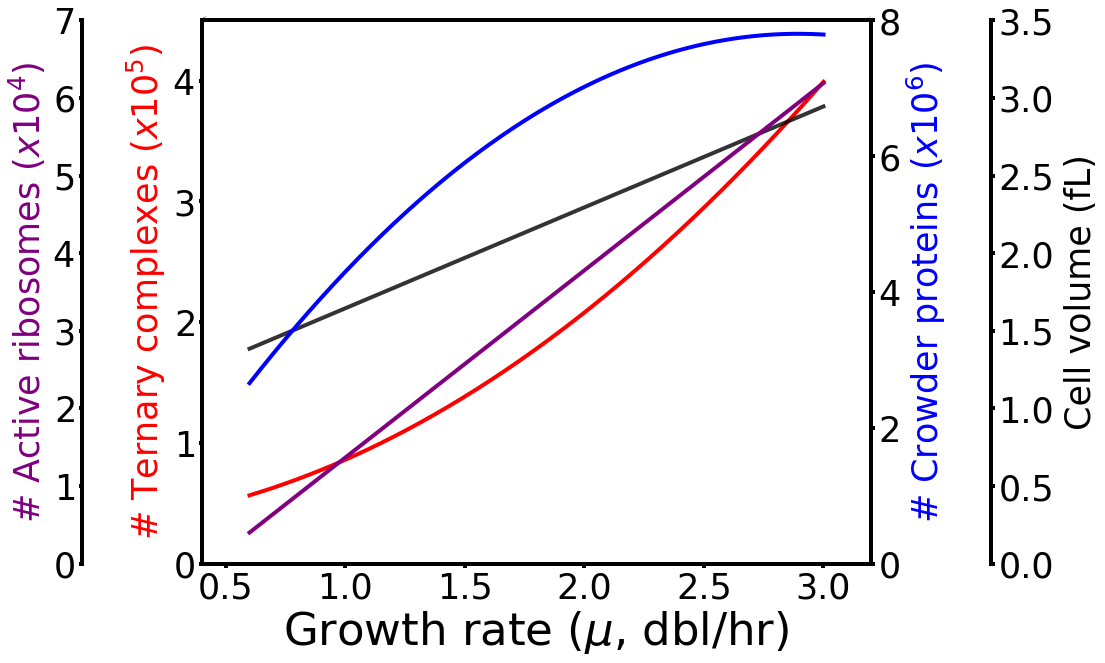

In [9]:
import matplotlib.ticker as mtick

fig = plt.figure(figsize=(12,10))

host = fig.add_subplot(111)

par2 = host.twinx()
par1 = host.twinx()

par3 = host.twinx()

host.set_xlim(0.4, 3.2)
par2.set_ylim(0, 3.5)
host.set_ylim(0, 450000)
par3.set_ylim(0, 70000)
par1.set_ylim(0, 8000000)

host.set_xlabel("Growth rate ($\mu$, dbl/hr)",size=45)
par2.set_ylabel("Cell volume (fL)",size=35,labelpad=10)
host.set_ylabel("# Ternary complexes "+"$(x10^5)$",size=35)
par3.set_ylabel("# Active ribosomes "+"$(x10^4)$",size=35)
par1.set_ylabel("# Crowder proteins "+"$(x10^6)$",size=35)

color1 = plt.cm.viridis(0)
color2 = plt.cm.viridis(0.6)
color3 = plt.cm.viridis(.9)
color4 = plt.cm.viridis(0.3)

p1, = host.plot(dbl_rate_list[1], tern, color='red', label="Ternary complexes",linewidth=4)

p2, = par2.plot(dbl_rate_list[3], vol, color='black',label="Cell volume",alpha=0.8,linewidth=4)

p3, = par1.plot(dbl_rate, crowderAbundance, color='blue', label="Crowder proteins",linewidth=4)

p4, = par3.plot(dbl_rate_list[0], ribs, color='purple', label="Active ribosomes",linewidth=4)


#lns = [p4,p1, p3,p2]
#host.legend(handles=lns, loc='best',prop={'size':20})

# right, left, top, bottom
par2.spines['right'].set_position(('outward', 120))

par3.spines['left'].set_position(('outward', 120)) 
par3.spines["left"].set_visible(True) 
par3.yaxis.set_label_position('left') 
par3.yaxis.set_ticks_position('left')# no x-ticks                 
#par3.xaxis.set_ticks([])
# no x-ticks                 
#par2.xaxis.set_ticks([])
# Sometimes handy, same for xaxis
#par2.yaxis.set_ticks_position('right')
#host.tick_params(axis='x', **tkw)


host.yaxis.label.set_color(p1.get_color())
par2.yaxis.label.set_color(p2.get_color())
par1.yaxis.label.set_color(p3.get_color())
par3.yaxis.label.set_color(p4.get_color())

formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3,3))
host.yaxis.offsetText.set_fontsize(0)
host.yaxis.set_major_formatter(formatter)
par3.yaxis.offsetText.set_fontsize(0)
par3.yaxis.set_major_formatter(formatter)
par1.yaxis.offsetText.set_fontsize(0)
par1.yaxis.set_major_formatter(formatter)

host.spines['left'].set_linewidth(4)
host.spines['bottom'].set_linewidth(4)
host.spines['top'].set_linewidth(4)
host.spines['right'].set_linewidth(4)
par3.spines['left'].set_linewidth(4)
par2.spines['right'].set_linewidth(4)

host.tick_params(axis='both', which='major',width=4, labelsize=35)
par3.tick_params(axis='both', which='major',width=4, labelsize=35)
par1.tick_params(axis='both', which='major',width=4, labelsize=35)
par2.tick_params(axis='both', which='major',width=4, labelsize=35)

#Note this graph doesn't account for doubling of # ribosomes; that would be confusing
#Could make a second graph with # tern and # rib for a voxel

In [ ]:
#P-site variation
import matplotlib.ticker as mtick

fig = plt.figure(figsize=(12,10))

host = fig.add_subplot(111)

par2 = host.twinx()
par1 = host.twinx()

par3 = host.twinx()

host.set_xlim(0.4, 3.2)
par2.set_ylim(0, 3.5)
host.set_ylim(0, 450000)
par3.set_ylim(0, 70000)
par1.set_ylim(0, 8000000)

host.set_xlabel("Growth rate ($\mu$, dbl/hr)",size=45)
par2.set_ylabel("Cell volume (fL)",size=35,labelpad=10)
host.set_ylabel("# Ternary complexes "+"$(x10^5)$",size=35)
par3.set_ylabel("# Active ribosomes "+"$(x10^4)$",size=35)
par1.set_ylabel("# Crowder proteins "+"$(x10^6)$",size=35)

color1 = plt.cm.viridis(0)
color2 = plt.cm.viridis(0.6)
color3 = plt.cm.viridis(.9)
color4 = plt.cm.viridis(0.3)

p1, = host.plot(dbl_rate_list[1], tern, color='red', label="Ternary complexes",linewidth=4)

p2, = par2.plot(dbl_rate_list[3], vol, color='black',label="Cell volume",alpha=0.8,linewidth=4)

p3, = par1.plot(dbl_rate, crowderAbundance, color='blue', label="Crowder proteins",linewidth=4)

p4, = par3.plot(dbl_rate_list[0], ribs, color='purple', label="Active ribosomes",linewidth=4)


#lns = [p4,p1, p3,p2]
#host.legend(handles=lns, loc='best',prop={'size':20})

# right, left, top, bottom
par2.spines['right'].set_position(('outward', 120))

par3.spines['left'].set_position(('outward', 120)) 
par3.spines["left"].set_visible(True) 
par3.yaxis.set_label_position('left') 
par3.yaxis.set_ticks_position('left')# no x-ticks                 
#par3.xaxis.set_ticks([])
# no x-ticks                 
#par2.xaxis.set_ticks([])
# Sometimes handy, same for xaxis
#par2.yaxis.set_ticks_position('right')
#host.tick_params(axis='x', **tkw)


host.yaxis.label.set_color(p1.get_color())
par2.yaxis.label.set_color(p2.get_color())
par1.yaxis.label.set_color(p3.get_color())
par3.yaxis.label.set_color(p4.get_color())

formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3,3))
host.yaxis.offsetText.set_fontsize(0)
host.yaxis.set_major_formatter(formatter)
par3.yaxis.offsetText.set_fontsize(0)
par3.yaxis.set_major_formatter(formatter)
par1.yaxis.offsetText.set_fontsize(0)
par1.yaxis.set_major_formatter(formatter)

host.spines['left'].set_linewidth(4)
host.spines['bottom'].set_linewidth(4)
host.spines['top'].set_linewidth(4)
host.spines['right'].set_linewidth(4)
par3.spines['left'].set_linewidth(4)
par2.spines['right'].set_linewidth(4)

host.tick_params(axis='both', which='major',width=4, labelsize=35)
par3.tick_params(axis='both', which='major',width=4, labelsize=35)
par1.tick_params(axis='both', which='major',width=4, labelsize=35)
par2.tick_params(axis='both', which='major',width=4, labelsize=35)

#Note this graph doesn't account for doubling of # ribosomes; that would be confusing
#Could make a second graph with # tern and # rib for a voxel

### Plot 1) number of crowders per cell vs. growth rate, and 2) abundances of ternary complexes, ribosomes, and crowders in a translation voxel across growth rate. Do so by instantiating cell/voxel parametrization class.

In [4]:
import matplotlib.ticker as mticker
formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3,2))
dbl_rate=np.arange(0.6,3.0,0.01)

fig,[ax0,ax1,ax2,ax3,ax4] = plt.subplots(5,1,figsize=(9.5,20))
for ax in [ax0,ax1,ax2,ax3,ax4]:   "source": [

    ax.yaxis.offsetText.set_fontsize(20)
    ax.yaxis.set_major_formatter(formatter)
    ax.plot(dbl_rate,crowderAbundance,color='black',linewidth=3)
    ax.spines['left'].set_linewidth(3)
    ax.spines['bottom'].set_linewidth(3)
    ax.spines['top'].set_linewidth(3)
    ax.spines['right'].set_linewidth(3)
    
    ax.set_ylabel('Abundance',size=25,labelpad=10)
    ax.set_xlabel('Growth rate (dbl/hr)',size=25,labelpad=10)
    ax.tick_params(axis='both', which='major',width=4, labelsize=20)
    ax.set_title('Crowders',fontsize=30,pad=10)
    plt.tight_layout(pad=3.0)

SyntaxError: invalid syntax (<ipython-input-4-98ef31c1ef42>, line 10)

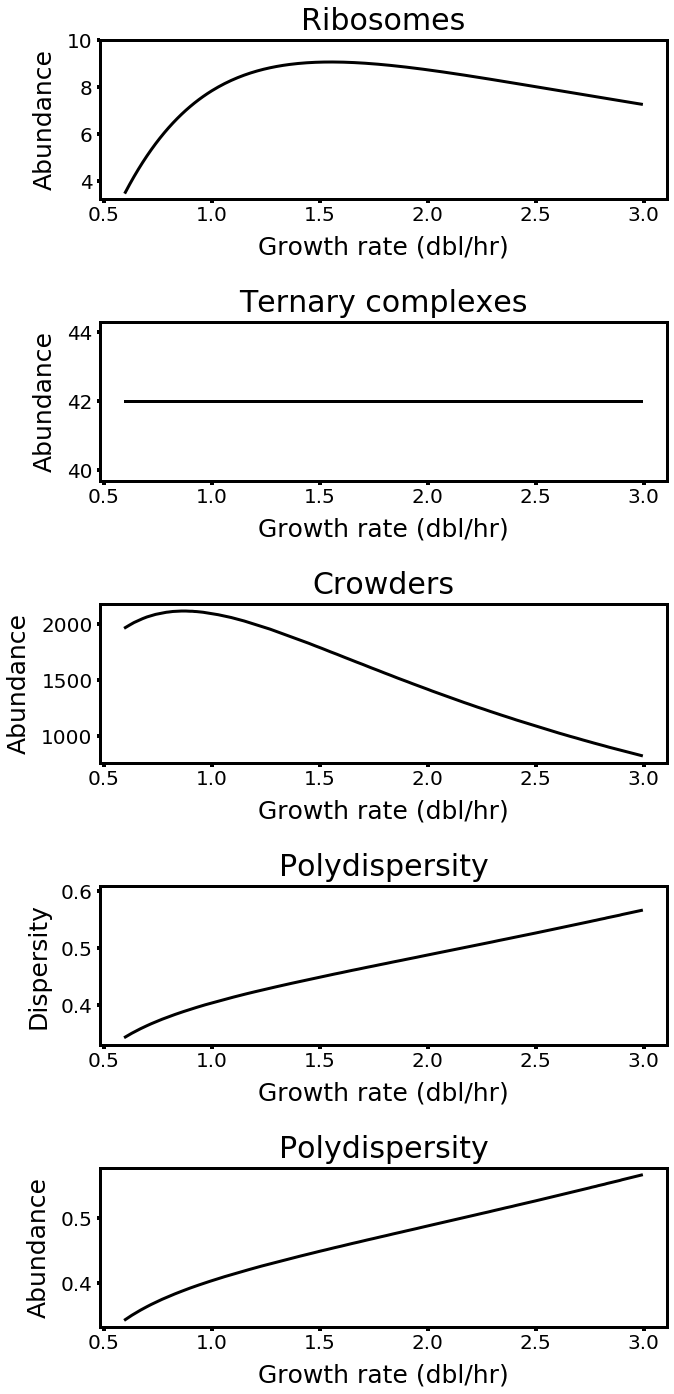

In [5]:
dbl_rate=np.arange(0.6,3.0,0.01)
ribAbundance_vox = list()
ternAbundance_vox = list()
crowderAbundance_vox = list()
dispersity_vox = list()
size_vox = list()

for i in range(len(dbl_rate)):
    cell_volfrac_tot = list()
    cellParams, voxelParams = calcParams(f_rib(dbl_rate[i]),
                                               f_tern(dbl_rate[i]),
                                               f_mass(dbl_rate[i]),
                                               f_vol(dbl_rate[i]),
                                               f_nuc(dbl_rate[i]))
    ribAbundance_vox.append(voxelParams[2][0])
    ternAbundance_vox.append(voxelParams[2][1])
    crowderAbundance_vox.append(voxelParams[2][2])
    dispersity_vox.append(voxelParams[1][4])
fig,ax = plt.subplots(5,1,figsize=(10,20))
dispersity = [0.12, 0.16, 0.20, 0.24, 0.28, 0.31]
abundances = [ribAbundance_vox,ternAbundance_vox, crowderAbundance_vox,dispersity_vox,dispersity_vox]
labels = ['Ribosomes','Ternary complexes', 'Crowders', 'Polydispersity','Polydispersity']

for i,count in enumerate(abundances):
    ax[i].plot(dbl_rate,count,color='black',linewidth=3)
    ax[i].spines['left'].set_linewidth(3)
    ax[i].spines['bottom'].set_linewidth(3)
    ax[i].spines['top'].set_linewidth(3)
    ax[i].spines['right'].set_linewidth(3)
    ax[i].set_ylabel('Abundance',size=25,labelpad=10)
    ax[i].set_xlabel('Growth rate (dbl/hr)',size=25,labelpad=10)
    ax[i].tick_params(axis='both', which='major',width=4, labelsize=20)
    ax[i].set_title(labels[i],fontsize=30,pad=10)
ax[3].set_ylabel('Dispersity',size=25,labelpad=10)

ax[0].set_yticks(np.arange(4, 10.1, 2))

ax[3].set_yticks(np.arange(0.3, 0.61, 0.1))
ax[3].set_ylim(0.33,0.61)
plt.tight_layout(pad=3.0)

### Plot 1) Change in total and relative volume fraction of the voxel with doubling rate, and 2) Change in empirical elongation time with voxel volume fraction

Total voxel volume fraction:  [0.22350472873485544, 0.22537394215772227, 0.2272770722917415, 0.22912987970741405, 0.2309744419882591, 0.23281081623049266, 0.23463905864797038, 0.23645922458915225, 0.23822749936402626, 0.24003140590278474, 0.2417829872001842, 0.2435261609949425, 0.2452609751027268, 0.24698747661958942, 0.24866021061390803, 0.25036994942658025, 0.2520254572272017, 0.2537186090300313, 0.2553570593483212, 0.2569869024682866, 0.2586081776691662, 0.26022092365618854, 0.2618251785710076, 0.26337295600343485, 0.26496005549951784, 0.26653877406934773, 0.2680602642400991, 0.26962203997714984, 0.2711260789233377, 0.2726212961606754, 0.27415776592119, 0.2756357250582059, 0.27710495559347825, 0.2785654873855142, 0.2800173498760889, 0.2814605720974789, 0.2828951826795472, 0.28432120985668047, 0.28573868147458326, 0.2870949189837798, 0.2884950612332213, 0.2898867283505655, 0.29126994670057266, 0.29259083018751686, 0.2939569250861598, 0.29531464738439894, 0.296609196768671, 0.29794994

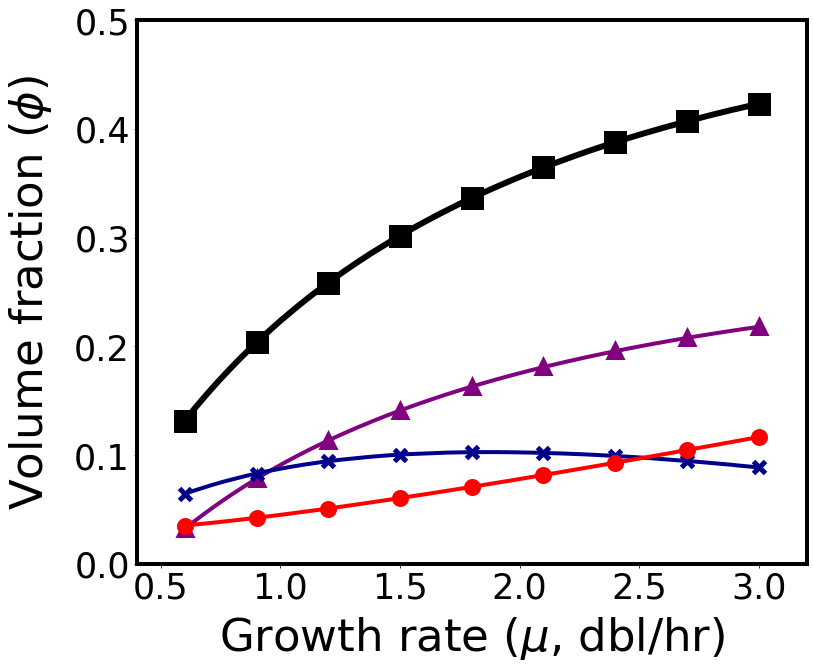

In [8]:
dbl_rate=np.arange(0.6,3.01,0.01)
vox_len = list()
rib_volfrac=list()
tern_volfrac = list()
crowder_volfrac = list()
total_volfrac =list()
for i in range(len(dbl_rate)):
    cell_volfrac_tot = list()
    cellParams, voxelParams = calcParams(f_rib(dbl_rate[i]),
                                               f_tern(dbl_rate[i]),
                                               f_mass(dbl_rate[i]),
                                               f_vol(dbl_rate[i]),
                                               f_nuc(dbl_rate[i]))
    vox_len.append(voxelParams[0])
    rib_volfrac.append(voxelParams[1][0])
    tern_volfrac.append(voxelParams[1][1])
    crowder_volfrac.append(voxelParams[1][2])
    total_volfrac.append(voxelParams[1][3])
    
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

fig,ax1 = plt.subplots(1,1,figsize=(12,10))

ax1.plot(dbl_rate,total_volfrac,label=r'$\mathregular{\phi_{ voxel}}$',color='black',marker='s',markersize=18,markeredgewidth=5,linewidth=6,markevery=30)
ax1.plot(dbl_rate,rib_volfrac,label=r'$\mathregular{\phi_{ ribosome}}$',color='purple',marker='^',markersize=12,markeredgewidth=5,linewidth=4,markevery=30)
ax1.plot(dbl_rate,crowder_volfrac,label=r'$\mathregular{\phi_{ protein}}$',color='darkblue',marker='x',markersize=12,markeredgewidth=5,linewidth=4,markevery=30)
ax1.plot(dbl_rate,tern_volfrac,label=r'$\mathregular{\phi_{ tRNA}}$',color='red',marker='o',markersize=12,markeredgewidth=5,linewidth=4,markevery=30)
#ax1.legend(loc='upper center', bbox_to_anchor=(1, 1.1),ncol=1,prop={'size':20})
#ax1.legend(prop={'size':25})
ax1.set_xlabel("Growth rate ($\mu$, dbl/hr)",fontsize=45,labelpad=10)
ax1.set_ylabel("Volume fraction ($\phi$)",fontsize=45,labelpad=20)
ax1.tick_params(axis='both', which='major', labelsize=35)
ax1.set_xlim(0.40,3.2)

ax1.set_ylim(0,0.5)
ax1.spines['right'].set_linewidth(4)
ax1.spines['left'].set_linewidth(4)
ax1.spines['top'].set_linewidth(4)
ax1.spines['bottom'].set_linewidth(4)


print#('Total voxel volume fraction: ', total_volfrac[40:301])
print#('\nRibosome volume fraction: ',rib_volfrac[40:301])
print#('\nCrowder volume fraction: ',crowder_volfrac[40:301])
print#('\nTernary complex volume fraction',tern_volfrac[40:301])

[Text(1, 0, '0'),
 Text(1, 0, '20'),
 Text(1, 0, '16.6'),
 Text(1, 0, '14.3'),
 Text(1, 0, '12.5')]

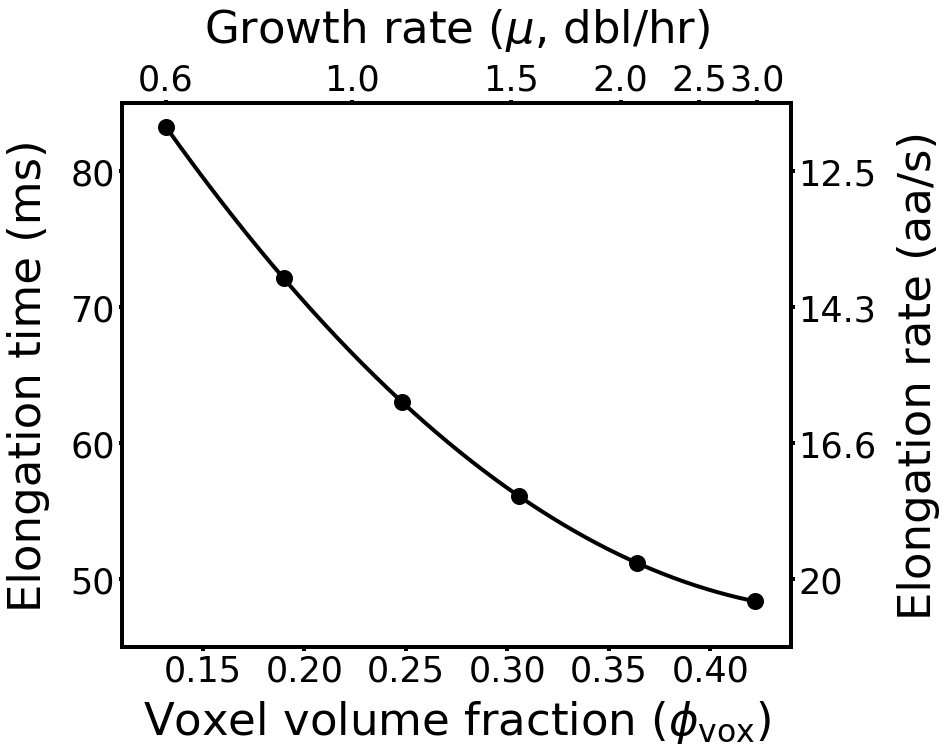

In [15]:
fig, ax = plt.subplots(1,1,figsize=(12,10))
phi_list=np.take(total_volfrac,[60-60,100-60,150-60,200-60,250-60,300-60])
y_model,SS_err,_,_,_ = np.polyfit(phi_list,[1000/12,1000/15,1000/18,1000/19,1000/20,1000/21],2,full=True)
y_hat = np.polyval(y_model,phi_list)
x_sweep_i = np.linspace(min(phi_list),max(phi_list),1000)
y_hat_sweep_i = np.polyval(y_model, x_sweep_i)
ax.plot(x_sweep_i,y_hat_sweep_i,marker='o',markersize=12,markeredgewidth=5,markevery=199,linewidth=4,color='black')
ax.tick_params(axis='both', which='major',width=4, labelsize=35)
ax.set_xlim(0.11,0.44)
ax.set_ylim(45,85)
ax.spines['left'].set_linewidth(4)
ax.spines['bottom'].set_linewidth(4)
ax.spines['top'].set_linewidth(4)
ax.spines['right'].set_linewidth(4)
ax.set_xlabel('Voxel volume fraction ($\phi_{\mathrm{vox}})$',size=45,color='black',labelpad=10)
ax.set_ylabel('Elongation time (ms)',size=45,color='black',labelpad=20)

ax1 = ax.twiny()
ax1.set_xlim(0.11,0.44)
ax1.tick_params(axis='both', which='major',width=4, labelsize=35)
#ax1.scatter(x_sweep_i,y_hat_sweep_i)
ax1.set_xticks(phi_list)
ax1.set_xlabel('Growth rate ($\mu$, dbl/hr)',size=45,color='black',labelpad=20)
labels = [item.get_text() for item in ax1.get_xticklabels()]
labels = ['0.6','1.0','1.5','2.0','2.5','3.0']
ax1.set_xticklabels(labels)
ax.set_xticks(np.arange(0.15,0.41,0.05))

ax2 = ax.twinx()
ax2.set_ylim(45,85)
ax2.tick_params(axis='both', which='major',width=4, labelsize=35)
ax2.set_ylabel('Elongation rate (aa/s)',size=45,color='black',labelpad=20)
labels = [item.get_text() for item in ax2.get_xticklabels()]
labels = ['0','20','16.6','14.3','12.5']
ax2.set_yticklabels(labels)

[0.13172292 0.22350473 0.30181037 0.35583449 0.3945994  0.42317604]


[Text(1, 0, '0'),
 Text(1, 0, '20'),
 Text(1, 0, '16.6'),
 Text(1, 0, '14.3'),
 Text(1, 0, '12.5')]

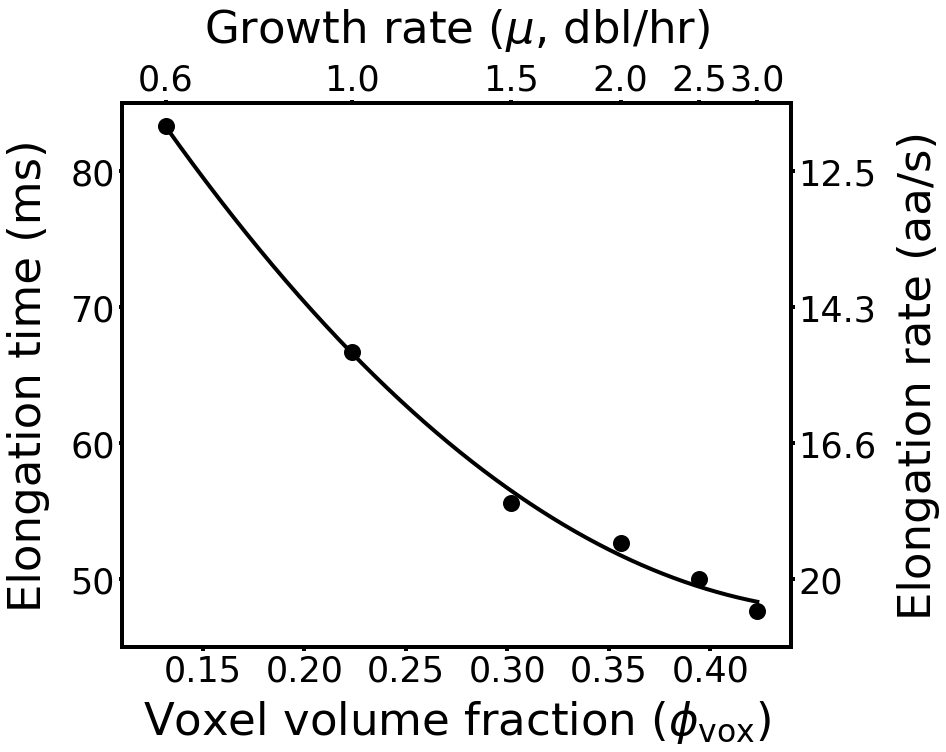

In [16]:
fig, ax = plt.subplots(1,1,figsize=(12,10))
phi_list=np.take(total_volfrac,[60-60,100-60,150-60,200-60,250-60,300-60])
print(phi_list)
y_model,SS_err,_,_,_ = np.polyfit(phi_list,[1000/12,1000/15,1000/18,1000/19,1000/20,1000/21],2,full=True)
y_hat = np.polyval(y_model,phi_list)
x_sweep_i = np.linspace(min(phi_list),max(phi_list),1000)
y_hat_sweep_i = np.polyval(y_model, x_sweep_i)
ax.errorbar(phi_list,[1000/12,1000/15,1000/18,1000/19,1000/20,1000/21],[0,0,0,0,0,0],marker='o',markersize=12,markeredgewidth=5,zorder=1,linewidth=0,color='black')
ax.plot(x_sweep_i,y_hat_sweep_i,marker='o',markersize=0,markeredgewidth=5,markevery=199,linewidth=4,color='black')
ax.tick_params(axis='both', which='major',width=4, labelsize=35)
ax.set_xlim(0.11,0.44)
ax.set_ylim(45,85)
ax.spines['left'].set_linewidth(4)
ax.spines['bottom'].set_linewidth(4)
ax.spines['top'].set_linewidth(4)
ax.spines['right'].set_linewidth(4)
ax.set_xlabel('Voxel volume fraction ($\phi_{\mathrm{vox}})$',size=45,color='black',labelpad=10)
ax.set_ylabel('Elongation time (ms)',size=45,color='black',labelpad=20)

ax1 = ax.twiny()
ax1.set_xlim(0.11,0.44)
ax1.tick_params(axis='both', which='major',width=4, labelsize=35)
#ax1.scatter(x_sweep_i,y_hat_sweep_i)
ax1.set_xticks(phi_list)
ax1.set_xlabel('Growth rate ($\mu$, dbl/hr)',size=45,color='black',labelpad=20)
labels = [item.get_text() for item in ax1.get_xticklabels()]
labels = ['0.6','1.0','1.5','2.0','2.5','3.0']
ax1.set_xticklabels(labels)
ax.set_xticks(np.arange(0.15,0.41,0.05))


ax2 = ax.twinx()
ax2.set_ylim(45,85)
ax2.tick_params(axis='both', which='major',width=4, labelsize=35)
ax2.set_ylabel('Elongation rate (aa/s)',size=45,color='black',labelpad=20)
labels = [item.get_text() for item in ax2.get_xticklabels()]
labels = ['0','20','16.6','14.3','12.5']
ax2.set_yticklabels(labels)

[0.13172292 0.22350473 0.30181037 0.35583449 0.3945994  0.42317604]


[Text(1, 0, '0'),
 Text(1, 0, '20'),
 Text(1, 0, '16.6'),
 Text(1, 0, '14.3'),
 Text(1, 0, '12.5')]

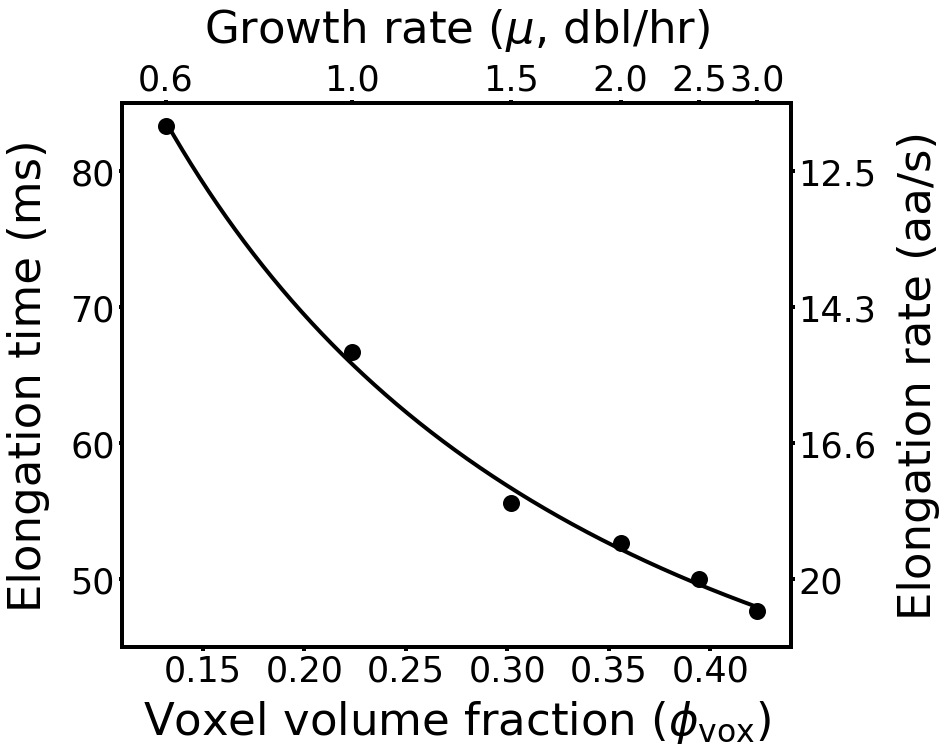

In [17]:
fig, ax = plt.subplots(1,1,figsize=(12,10))
phi_list=np.take(total_volfrac,[60-60,100-60,150-60,200-60,250-60,300-60])
print(phi_list)
y_model,SS_err,_,_,_ = np.polyfit(phi_list,[12,15,18,19,20,21],2,full=True)
y_hat = np.polyval(y_model,phi_list)
x_sweep_i = np.linspace(min(phi_list),max(phi_list),1000)
y_hat_sweep_i = np.polyval(y_model, x_sweep_i)
ax.errorbar(phi_list,[1000/12,1000/15,1000/18,1000/19,1000/20,1000/21],[0,0,0,0,0,0],marker='o',markersize=12,markeredgewidth=5,zorder=1,linewidth=0,color='black')
ax.plot(x_sweep_i,1000/np.array(y_hat_sweep_i),marker='o',markersize=0,markeredgewidth=5,markevery=199,linewidth=4,color='black')
ax.tick_params(axis='both', which='major',width=4, labelsize=35)
ax.set_xlim(0.11,0.44)
ax.set_ylim(45,85)
ax.spines['left'].set_linewidth(4)
ax.spines['bottom'].set_linewidth(4)
ax.spines['top'].set_linewidth(4)
ax.spines['right'].set_linewidth(4)
ax.set_xlabel('Voxel volume fraction ($\phi_{\mathrm{vox}})$',size=45,color='black',labelpad=10)
ax.set_ylabel('Elongation time (ms)',size=45,color='black',labelpad=20)

ax1 = ax.twiny()
ax1.set_xlim(0.11,0.44)
ax1.tick_params(axis='both', which='major',width=4, labelsize=35)
#ax1.scatter(x_sweep_i,y_hat_sweep_i)
ax1.set_xticks(phi_list)
ax1.set_xlabel('Growth rate ($\mu$, dbl/hr)',size=45,color='black',labelpad=20)
labels = [item.get_text() for item in ax1.get_xticklabels()]
labels = ['0.6','1.0','1.5','2.0','2.5','3.0']
ax1.set_xticklabels(labels)
ax.set_xticks(np.arange(0.15,0.41,0.05))


ax2 = ax.twinx()
ax2.set_ylim(45,85)
ax2.tick_params(axis='both', which='major',width=4, labelsize=35)
ax2.set_ylabel('Elongation rate (aa/s)',size=45,color='black',labelpad=20)
labels = [item.get_text() for item in ax2.get_xticklabels()]
labels = ['0','20','16.6','14.3','12.5']
ax2.set_yticklabels(labels)

[0.13172292 0.22350473 0.30181037 0.35583449 0.3945994  0.42317604]


[Text(1, 0, '0'),
 Text(1, 0, '20.0'),
 Text(1, 0, '16.6'),
 Text(1, 0, '14.3'),
 Text(1, 0, '12.5')]

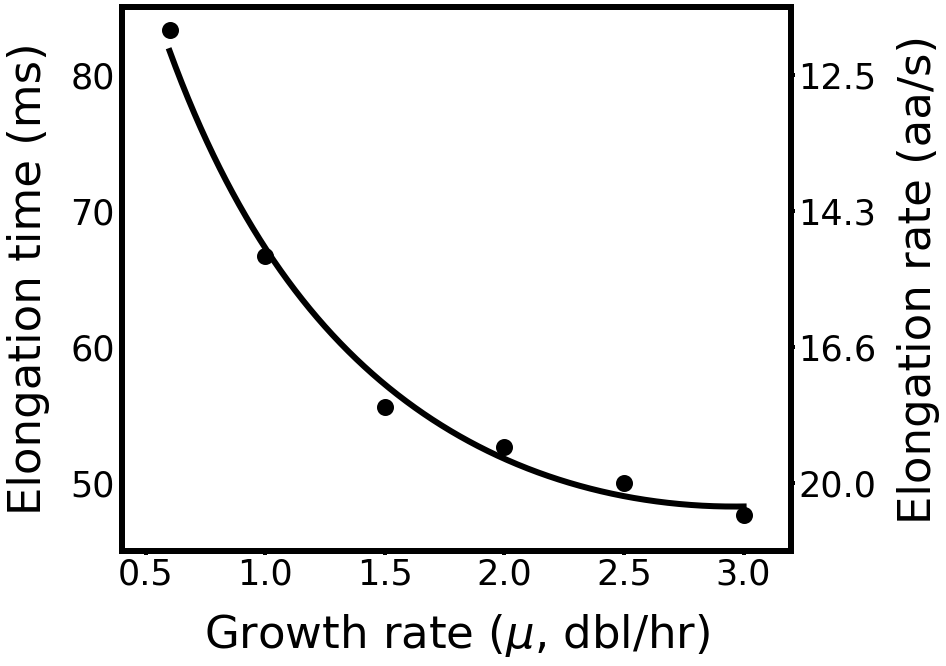

In [28]:
gr_list = [0.6,1.0,1.5,2.0,2.5,3.0]
fig, ax = plt.subplots(1,1,figsize=(12,10))
phi_list=np.take(total_volfrac,[60-60,100-60,150-60,200-60,250-60,300-60])
print(phi_list)
y_model,SS_err,_,_,_ = np.polyfit(gr_list,[12,15,18,19,20,21],2,full=True)
y_hat = np.polyval(y_model,gr_list)
x_sweep_i = np.linspace(min(gr_list),max(gr_list),1000)
y_hat_sweep_i = np.polyval(y_model, x_sweep_i)
ax.errorbar(gr_list,[1000/12,1000/15,1000/18,1000/19,1000/20,1000/21],[0,0,0,0,0,0],marker='o',markersize=12,markeredgewidth=5,zorder=1,linewidth=0,color='black')
ax.plot(x_sweep_i,1000/np.array(y_hat_sweep_i),marker='o',markersize=0,markeredgewidth=5,markevery=199,linewidth=6,color='black')
ax.tick_params(axis='both', which='major',width=4, labelsize=35)
ax.set_xlim(0.4,3.2)
ax.set_ylim(45,85)
ax.spines['left'].set_linewidth(6)
ax.spines['bottom'].set_linewidth(6)
ax.spines['top'].set_linewidth(6)
ax.spines['right'].set_linewidth(6)
ax.set_xlabel('Growth rate ($\mu$, dbl/hr)',size=45,color='black',labelpad=20)
ax.set_ylabel('Elongation time (ms)',size=45,color='black',labelpad=20)


ax2 = ax.twinx()
ax2.set_ylim(45,85)
ax2.tick_params(axis='both', which='major',width=4, labelsize=35)
ax2.set_ylabel('Elongation rate (aa/s)',size=45,color='black',labelpad=20)
labels = [item.get_text() for item in ax2.get_xticklabels()]
labels = ['0','20.0','16.6','14.3','12.5']
ax2.set_yticklabels(labels)

[0.13172292 0.22350473 0.30181037 0.35583449 0.3945994  0.42317604]


[Text(1, 0, '0'),
 Text(1, 0, '20'),
 Text(1, 0, '16.6'),
 Text(1, 0, '14.3'),
 Text(1, 0, '12.5')]

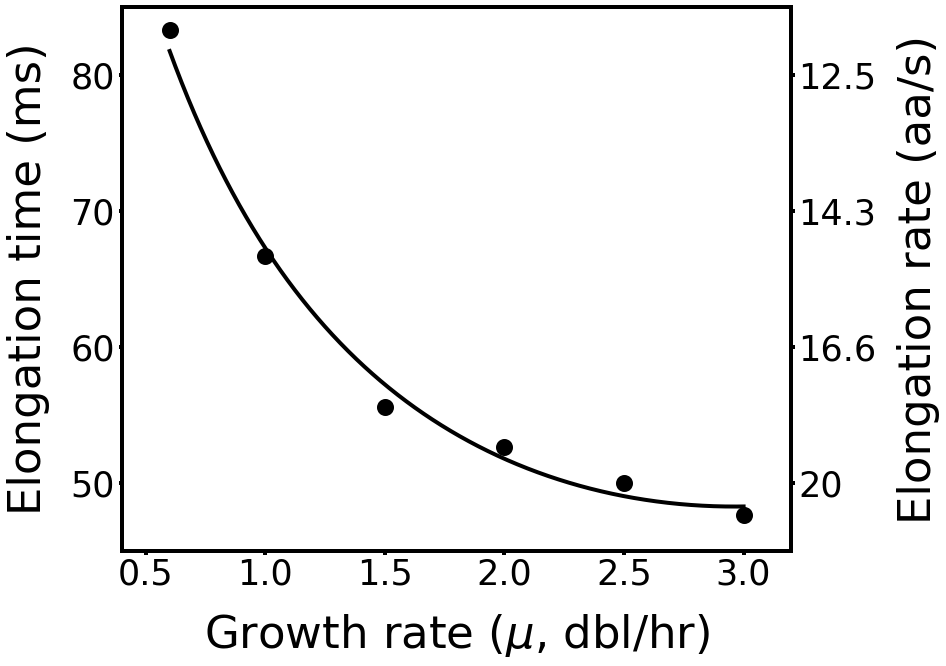

In [19]:
gr_list = [0.6,1.0,1.5,2.0,2.5,3.0]
fig, ax = plt.subplots(1,1,figsize=(12,10))
phi_list=np.take(total_volfrac,[60-60,100-60,150-60,200-60,250-60,300-60])
print(phi_list)
y_model,SS_err,_,_,_ = np.polyfit(gr_list,[12,15,18,19,20,21],2,full=True)
y_hat = np.polyval(y_model,gr_list)
x_sweep_i = np.linspace(min(gr_list),max(gr_list),1000)
y_hat_sweep_i = np.polyval(y_model, x_sweep_i)
ax.errorbar(gr_list,[1000/12,1000/15,1000/18,1000/19,1000/20,1000/21],[0,0,0,0,0,0],marker='o',markersize=12,markeredgewidth=5,zorder=1,linewidth=0,color='black')
ax.plot(x_sweep_i,1000/np.array(y_hat_sweep_i),marker='o',markersize=0,markeredgewidth=5,markevery=199,linewidth=4,color='black')
ax.tick_params(axis='both', which='major',width=4, labelsize=35)
ax.set_xlim(0.4,3.2)
ax.set_ylim(45,85)
ax.spines['left'].set_linewidth(4)
ax.spines['bottom'].set_linewidth(4)
ax.spines['top'].set_linewidth(4)
ax.spines['right'].set_linewidth(4)
ax.set_xlabel('Growth rate ($\mu$, dbl/hr)',size=45,color='black',labelpad=20)
ax.set_ylabel('Elongation time (ms)',size=45,color='black',labelpad=20)


ax2 = ax.twinx()
ax2.set_ylim(45,85)
ax2.tick_params(axis='both', which='major',width=4, labelsize=35)
ax2.set_ylabel('Elongation rate (aa/s)',size=45,color='black',labelpad=20)
labels = [item.get_text() for item in ax2.get_xticklabels()]
labels = ['0','20','16.6','14.3','12.5']
ax2.set_yticklabels(labels)


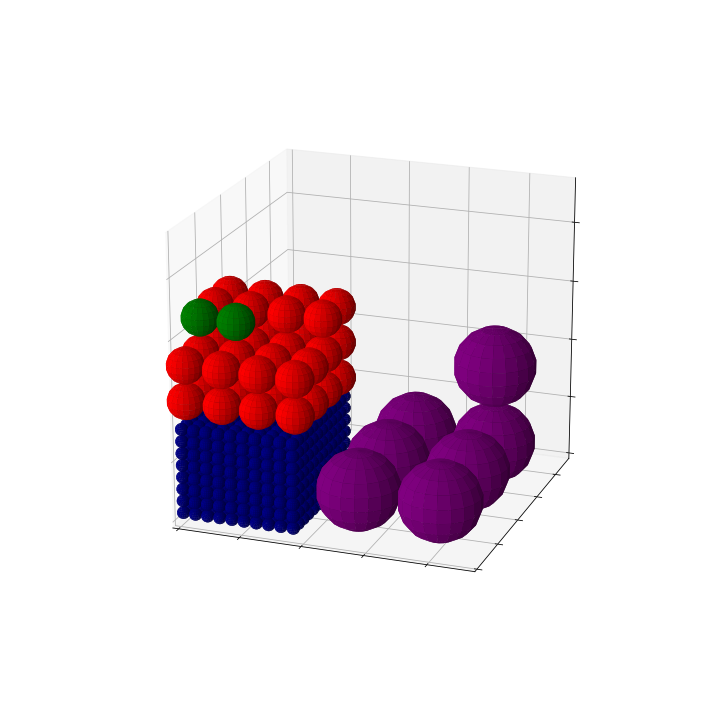

In [18]:
import matplotlib.pyplot as plt
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
import numpy as np

# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
#ax.set_aspect("equal")

# draw cuboids in the top left and bottom right corners, and a link between them
crowder=0
for i in range(10):
    for j in range(12):
        for k in range(8):
            if(crowder<2000):
                crowder+=1
                u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
                x = 2*np.cos(u)*np.sin(v)
                y = 2*np.sin(u)*np.sin(v)
                z = 2*np.cos(v)
                ax.plot_surface(4*i+x, 2+4*j+y, 2+4*k+z, color="darkblue")

tRNA=0
for k in range(4):
    for j in range(3,-1,-1):
        for i in range(4):
            if(tRNA<42):
                tRNA+=1
                u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
                x = (5.9)*np.cos(u)*np.sin(v)
                y = (5.9)*np.sin(u)*np.sin(v)
                z = (5.9)*np.cos(v)
                c='r'
                if tRNA>40:
                    c='g'
                ax.plot_surface(11.8*i+x, 5.9+11.8*j+y, 38+11.8*k+z, color=c)
ribosome=0
for k in range(2):
    for j in range(2,-1,-1):
        for i in range(1,-1,-1):
            if(ribosome<7):
                ribosome+=1
                u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
                x =13*np.cos(u)*np.sin(v)
                y = 13*np.sin(u)*np.sin(v)
                z = 13*np.cos(v)
                ax.plot_surface(53+26*i+x, 13+26*j+y, 13+26*k+z, color="purple")

ax.view_init(20, -70)

ax.set_xlim3d(0,93)
ax.set_ylim3d(0,93)
ax.set_zlim3d(0,93)
#ax.set_xlabel('\n\n nm',size=30)
#ax.set_ylabel('\n\n nm',size=30)
#ax.set_zlabel('\n\n nm',size=30)
ax.tick_params(axis='both', which='major', labelsize=22)
ax.tick_params(labelbottom=False)    
ax.tick_params(labelleft=False)    
#ax.get_yaxis().set_ticks([])
#ax.zaxis.set_ticks([])
#ax.set_axis_off()


plt.savefig('deconstructedcell.png',transparent=True)
plt.show()

In [143]:
dbl_rate=[0.6,1.0,1.5,2.0,2.5,3.0]
vox_vol = list()
rib_num=list()
tern_num = list()
crowder_num = list()
total_volfrac =list()
rib_volfrac=list()
tern_volfrac=list()
crowder_volfrac=list()
for i in range(len(dbl_rate)):
    cell_volfrac_tot = list()
    cellParams, voxelParams = calcParams(f_rib(dbl_rate[i]),
                                               f_tern(dbl_rate[i]),
                                               f_mass(dbl_rate[i]),
                                               f_vol(dbl_rate[i]),
                                               f_nuc(dbl_rate[i]))
    vox_vol.append(voxelParams[0]**3*10**9)
    rib_num.append(voxelParams[2][0])
    tern_num.append(voxelParams[2][1])
    crowder_num.append(voxelParams[2][2])
    total_volfrac.append(voxelParams[1][3])
    rib_volfrac.append(voxelParams[1][0])
    tern_volfrac.append(voxelParams[1][1])
    crowder_volfrac.append(voxelParams[1][2])

print(vox_vol,rib_num,tern_num,crowder_num,total_volfrac)

vox_r = (np.array(vox_vol)*3/(4*3.1415))**(1/3)
vox_area = vox_r**2*3.1415
molec_r =np.multiply(vox_r,total_volfrac)
molec_area = np.multiply(vox_area,total_volfrac)
print(vox_r,vox_area)
print(molec_r,molec_area)

[1025879.5640663747, 802442.1644599059, 597822.5269429875, 463436.9524843348, 373192.64930004225, 309986.6364523099] [3.543136880773271, 7.839397087914931, 9.053235633635474, 8.728526590655452, 8.013776336457536, 7.258097524079431] [42, 42, 42, 42, 42, 42] [1970.0, 2096.0, 1791.0, 1418.0, 1090.0, 820.0] [0.1317229236080266, 0.22350472873485533, 0.3018103707556111, 0.35583449280323365, 0.3945993989845797, 0.4231760391314746]
[62.56625965 57.64734541 52.25952906 48.00704263 44.66346645 41.98450692] [12297.51750219 10439.88442291  8579.61989414  7240.14009922
  6266.74347602  5537.51834674]
[ 8.24141064 12.8844543  15.77246784 17.08256166 17.62417702 17.76683734] [1619.86495851 2333.36353597 2589.41826119 2576.29158003 2472.85320923
 2343.34508059]


In [106]:
x = np.array(vox_vol)
vox_r = (x*3/(4*3.1415))**(1/3)


In [107]:
x = np.multiply(vox_r,total_volfrac)
molec_r = (x*3/(4*3.1415))**(1/3)
print(vox_r)
print(molec_r)

[62.56625965 57.64734541 52.25952906 48.00704263 44.66346645 41.98450692]
[1.25306976 1.4543315  1.55575528 1.59768957 1.6143995  1.61874376]


In [116]:
(3/(4*3.1415)*np.array(total_volfrac))**(1/3)

array([0.31564229, 0.37647572, 0.41612083, 0.43959973, 0.45501621,
       0.46574524])

In [124]:
((1/(4*3.141592))*np.array(vox_vol))**(1/2)

array([285.72175067, 252.69810406, 218.11284929, 192.03944535,
       172.3303038 , 157.06036379])

In [123]:
((1/(4*3.141592))*np.array(vox_vol)*total_volfrac)**(1/2)

array([103.69886026, 119.46628025, 119.82524636, 114.55510956,
       108.25298071, 102.17087993])

In [132]:
(((1/(4*3.141592))*np.array(vox_vol)*total_volfrac)**(1/2))/(((1/(4*3.141592))*np.array(vox_vol))**(1/2))

array([0.36293653, 0.47276287, 0.54937271, 0.59651864, 0.62817147,
       0.65051982])

In [ ]:
#1.5 36.006010140912196 33.35525978532522 2.650750355586974 0.0645362370530545

#2.5 20.690964889566583 18.23897323585892 2.451991653707661 0.10163176766929363

#4.0 12.432661982064621 10.801458116791515 1.631203865273107  0.15135985804782126

#5.0 10.101373610833413 8.688822547853192 1.4125510629802216 0.1782995132269649

#7.5 7.443903408643389 6.213537813064666 1.230365595578723 0.24296942227041737

#10 6.025134629366314 4.834037819054032 1.1910968103122828 0.2891755744976792

#Gap: [40.966656   24.29998933 13.18887822 10.26490161  7.63332267  5.25237029]

#Preloading:
preload_trans = np.array( [50.283661834970495, 44.87645812125916, 42.583016937953644, 42.583016937953644, 43.542832403247125, 45.26182178661661]  )
preload_rxn =  np.array( [4.857358813174258, 10.049302214512807, 11.112347973074085, 11.112347973074085, 9.7677334393338, 8.627008491200282]  )
preload_elong = np.array([55.141020648144746, 54.92576033577197, 53.695364911027724, 53.695364911027724, 53.31056584258094, 53.88883027781689]  )
preload_elong_sem = np.array([0.20995772209584967, 0.21234967588820844, 0.2098744749887588, 0.2098744749887588, 0.20656872508675034, 0.2044934905656416]  ) 

#Presorting+Preloading:
presortpreload_trans=np.array([ 33.35525978532522,18.23897323585892, 10.801458116791515, 8.688822547853192,6.213537813064666, 4.834037819054032])
presortpreload_rxn = np.array([ 2.650750355586974, 2.451991653707661,1.631203865273107, 1.4125510629802216, 1.230365595578723, 1.1910968103122828])
presortpreload_elong = presortpreload_trans+presortpreload_rxn
presortpreload_sem= np.array(0.1401328363502221, 0.0806555517707841, 0.04921750637308807, 0.040589519289063014, 0.03008424863984037, 0.024114695631412122)

#BM-only
bm_only_elong = np.array([297.7690828218327, 287.0317555046732, 214.16154690692883, 170.798688582851, 157.50219704468827, 135.1109224900536] )
bm_only_elong_sem = np.array([15.82499006018569, 18.932319519302787, 11.582631775363398, 8.220618561989044, 7.10059912538712, 5.863884903244429])

bm_only_trans = np.array( [241.98979332634306, 216.29638404953016, 148.7915624889631, 111.29650086910964, 101.69677914955025, 83.02328180376576]
)
bm_only_tranport_sem = np.array( [15.02609607042069, 16.78354800954726, 10.03590710312862, 7.091571679799831, 6.303865405961744, 5.155009095424843]
)

bm_only_rxn =  np.array( [55.779289495489614, 70.73537145514294, 65.36998441796574, 59.502187713741364, 55.805417895138035, 52.08764068628781]
)
bm_only_rxn_sem = np.array( [1.1653301793139563, 2.3896904099865064, 1.7394942942704879, 1.2512839939428426, 0.892753942092544, 0.7938581637983319]
)

#Bias
bias = np.array([1.5,2.5,4.0,5.0,7.5,10.0])

#Cognate binding probability
pbind = np.array([0.0645362370530545,0.10163176766929363, 0.15135985804782126,  0.1782995132269649, 0.24296942227041737, 0.2891755744976792])
